In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
from matplotlib import patches
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML

from helpers import *

## Load fixation events

In [2]:
base_dir = '%s/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN'%os.environ['HOME']

In [3]:
all_fix = pd.read_csv(base_dir + '/Study2_EyeTracking/Data/Cleaned/Gaze_events/all_fixations.csv', index_col = 0)

In [4]:
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat
2,158471.0,546.94,166.93,5,1,L,1.0,opt_nat
3,125121.0,595.40,9.29,5,1,L,1.0,opt_nat
4,158525.0,703.15,112.04,5,1,L,1.0,opt_nat


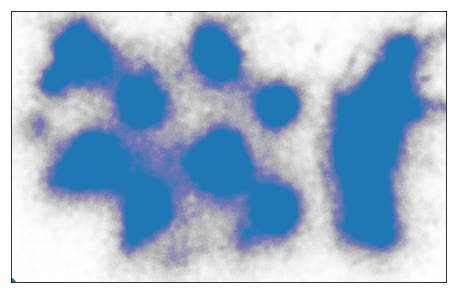

In [5]:
fig, ax = plt.subplots(1,1,figsize = [8,5])
ax.scatter(all_fix['x'], all_fix['y'], alpha = 0.005)
ax.set(xlim = [0,1680], ylim = [0,1050], xticks = [], yticks = [], aspect = 1);

## Tag with ROIs

In [6]:
number_locations = get_number_locations_indices()
number_locations.head()

,num,X,Y
0,10_1,250,485
1,10_2,507,280
2,S_1,813,485
3,T_1,1050,280
4,T_2,250,900


In [9]:
ROI_radius = 100
for ri,row in number_locations.iterrows():
    num, X, Y = row
    print(num,X,Y)
    all_fix[num] = all_fix.apply(lambda x:
             np.sqrt(np.square(x['x'] - X) + np.square(x['y'] - Y)) < ROI_radius,
            axis = 1)

10_1 250 485
10_2 507 280
S_1 813 485
T_1 1050 280
T_2 250 900
S_2 507 695
5_1 813 900
5_2 1050 695


KeyError: '10_1'

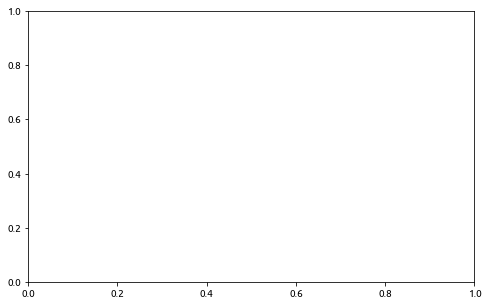

In [8]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
for target in number_locations['num'].unique():
    ax.scatter(all_fix.loc[all_fix[target]]['x'],all_fix.loc[all_fix[target]]['y'],alpha=.005)
    ax.set(xlim = [0,1680], ylim = [0,1050], aspect = 1)
    ax.scatter(*number_locations.query('num == @target')[['X','Y']].values[0], 100, c = 'r')
ax.invert_yaxis()

In [ ]:
all_fix.to_csv(base_dir +
   '/Study2_EyeTracking/Data/Cleaned/Gaze_events/'+
   'all_fixations_tagged_ROI_radius-%i.csv'%ROI_radius)

## Load

In [8]:
all_fix = pd.read_csv(base_dir +
               '/Study2_EyeTracking/Data/Cleaned/Gaze_events/all_fixations_tagged_ROI_radius-%i.csv'%ROI_radius,
                     index_col = 0)
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,False,True,False,False,False,False
2,158471.0,546.94,166.93,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
3,125121.0,595.40,9.29,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
4,158525.0,703.15,112.04,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False


## Limit to payoff matrix only

In [9]:
all_fix = all_fix.loc[(all_fix['x'] >= 200) & (all_fix['x'] <= 1120) &
                      (all_fix['y'] >= 200) & (all_fix['y'] <= 950),:].reset_index(drop=True)

## Compare gaze across conditions

In [10]:
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,False,True,False,False,False,False
2,183510.0,707.59,320.82,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
3,150135.0,801.86,404.91,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
4,158498.0,703.38,524.64,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False


In [11]:
num_fixations = all_fix.iloc[:,-8:]

In [12]:
num_fixations['num'] = num_fixations.apply(lambda x: number_locations['num'].values.tolist()[x.tolist().index(True)]
                    if True in x.tolist() else np.nan, axis=1)

In [13]:
num_fixations.head()

,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2,num
0,False,False,True,False,False,False,False,False,S_1
1,False,False,False,True,False,False,False,False,T_1
2,False,False,False,False,False,False,False,False,NaN
3,False,False,True,False,False,False,False,False,S_1
4,False,False,False,False,False,False,False,False,NaN


In [14]:
all_fix['num'] = num_fixations['num']

In [15]:
all_fix['part'] = all_fix['block'].apply(lambda x: 1 if x < 5 else 2)

In [16]:
all_fix['S'] = all_fix['S_1'] | all_fix['S_2']

In [17]:
all_fix['T'] = all_fix['T_1'] | all_fix['T_2']

In [18]:
all_fix['num_S_T'] = np.nan
all_fix.loc[all_fix['S'],'num_S_T'] = 'S'
all_fix.loc[all_fix['T'],'num_S_T'] = 'T'

In [19]:
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,...,T_1,T_2,S_2,5_1,5_2,num,part,S,T,num_S_T
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,...,False,False,False,False,False,S_1,1,True,False,S
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,...,True,False,False,False,False,T_1,1,False,True,T
2,183510.0,707.59,320.82,5,1,L,1.0,opt_nat,False,False,...,False,False,False,False,False,NaN,1,False,False,NaN
3,150135.0,801.86,404.91,5,1,L,1.0,opt_nat,False,False,...,False,False,False,False,False,S_1,1,True,False,S
4,158498.0,703.38,524.64,5,1,L,1.0,opt_nat,False,False,...,False,False,False,False,False,NaN,1,False,False,NaN


In [20]:
len(all_fix['sub'].unique())

50

In [21]:
pts = ['opt_nat','pess_nat','opt_inv','pess_inv']

##### Compute percentage of gaze within matrix

In [22]:
# Need a dataframe with one trial per row => dur sorted under num-named columns
afp = all_fix.pivot_table(index = ['sub','trial'], columns = 'num', values = 'dur', aggfunc=np.sum)
afp.head()

num             10_1       10_2       5_1  5_2        S_1       S_2       T_1  \
sub trial                                                                       
5   1      1134721.0  1084537.0       NaN  NaN  1092691.0       NaN  442096.0   
    2      1768729.0  1852025.0  208505.0  NaN   633707.0       NaN       NaN   
    3       717332.0   867566.0  658981.0  NaN   316985.0       NaN       NaN   
    4       175132.0        NaN  150129.0  NaN   951011.0  300418.0       NaN   
    5      1067937.0   892612.0  417156.0  NaN   926103.0       NaN       NaN   

num              T_2  
sub trial             
5   1      1092820.0  
    2       417223.0  
    3            NaN  
    4       708986.0  
    5      1042555.0

In [23]:
afp_pct = afp.apply(lambda x: x.values / x.sum(), axis = 1, result_type = 'broadcast').reset_index()
afp_pct.head()

num,sub,trial,10_1,10_2,5_1,5_2,S_1,S_2,T_1,T_2
0,5,1,0.234114,0.223761,NaN,NaN,0.225443,NaN,0.091213,0.225469
1,5,2,0.362430,0.379499,0.042725,NaN,0.129853,NaN,NaN,0.085493
2,5,3,0.280113,0.338779,0.257328,NaN,0.123780,NaN,NaN,NaN
3,5,4,0.076622,NaN,0.065683,NaN,0.416074,0.131435,NaN,0.310187
4,5,5,0.245708,0.205370,0.095978,NaN,0.213075,NaN,NaN,0.239868


In [24]:
afp_pct_melt = afp_pct.melt(id_vars = ['sub','trial'], var_name = 'num', value_name = 'dur_pct').sort_values(
    by = ['sub','trial','num']).reset_index(drop=True)
afp_pct_melt.head()

,sub,trial,num,dur_pct
0,5,1,10_1,0.234114
1,5,1,10_2,0.223761
2,5,1,5_1,NaN
3,5,1,5_2,NaN
4,5,1,S_1,0.225443


In [25]:
num_pct = all_fix[['sub','part','block','player_type','trial','num','eye']].merge(
    afp_pct_melt, on = ['sub','trial','num']).drop_duplicates().reset_index(drop=True).copy()
num_pct['num_S_T'] = np.nan
num_pct.loc[(num_pct['num'] == 'S_1') | (num_pct['num'] == 'S_2'),'num_S_T'] = 'S'
num_pct.loc[(num_pct['num'] == 'T_1') | (num_pct['num'] == 'T_2'),'num_S_T'] = 'T'
num_pct = num_pct[['sub','part','block','player_type','trial','eye','num_S_T','num','dur_pct']]
num_pct.head()

,sub,part,block,player_type,trial,eye,num_S_T,num,dur_pct
0,5,1,1.0,opt_nat,1,L,S,S_1,0.225443
1,5,1,1.0,opt_nat,1,L,T,T_1,0.091213
2,5,1,1.0,opt_nat,1,R,T,T_1,0.091213
3,5,1,1.0,opt_nat,1,L,NaN,10_2,0.223761
4,5,1,1.0,opt_nat,1,R,NaN,10_2,0.223761


##### Organize by trial/condition

In [26]:
# plot_dat = all_fix[['sub','part','block','player_type','trial','eye','num','S','T','num_S_T','dur']].copy()
plot_dat = num_pct.query('eye == "L"').copy().dropna().reset_index(drop=True)
plot_dat.head()

,sub,part,block,player_type,trial,eye,num_S_T,num,dur_pct
0,5,1,1.0,opt_nat,1,L,S,S_1,0.225443
1,5,1,1.0,opt_nat,1,L,T,T_1,0.091213
2,5,1,1.0,opt_nat,1,L,T,T_2,0.225469
3,5,1,1.0,opt_nat,2,L,S,S_1,0.129853
4,5,1,1.0,opt_nat,2,L,T,T_2,0.085493


##### Across player types

In [27]:
sub_fix = plot_dat.groupby(['sub','part','player_type','trial','num_S_T']).sum().groupby(
    ['sub','part','player_type','num_S_T']).mean().reset_index()
sub_fix = sub_fix[['sub','part','player_type','num_S_T','dur_pct']]
# sub_fix['dur'] = sub_fix['dur']/1e6
sub_fix.head()

,sub,part,player_type,num_S_T,dur_pct
0,5,1,opt_inv,S,0.303326
1,5,1,opt_inv,T,0.223195
2,5,1,opt_nat,S,0.217347
3,5,1,opt_nat,T,0.277543
4,5,1,pess_inv,S,0.303789


## These results are outdated - time NOT on number is NOT counted here! See gaze_by_condition_time.ipynb

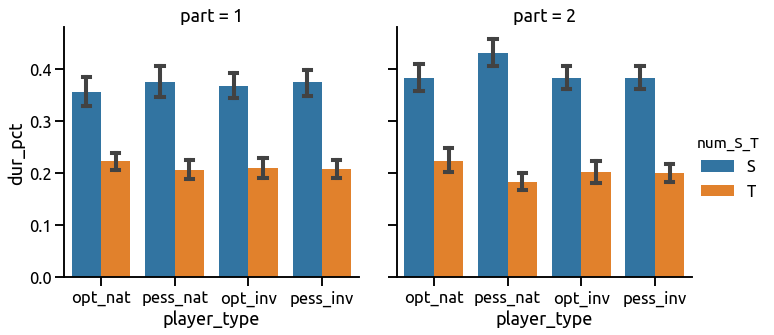

In [254]:
sns.set_context('talk')
sns.catplot(kind = 'bar', data = sub_fix, x = 'player_type', y = 'dur_pct', hue = 'num_S_T', order = pts,
           col = 'part', capsize = .1)

In [120]:
# Split by early/late trials

In [255]:
plot_dat['block_trial'] = (plot_dat['trial'] - np.floor(np.divide(plot_dat['trial'],16.001))*16).astype(int)

In [256]:
plot_dat['phase'] = plot_dat['block_trial'].apply(lambda x: 'early' if x < 9 else 'late')
plot_dat.head()

,sub,part,block,player_type,trial,eye,num_S_T,num,dur_pct,block_trial,phase
0,5,1,1.0,opt_nat,1,L,S,S_1,0.225443,1,early
1,5,1,1.0,opt_nat,1,L,T,T_1,0.091213,1,early
2,5,1,1.0,opt_nat,1,L,T,T_2,0.225469,1,early
3,5,1,1.0,opt_nat,2,L,S,S_1,0.129853,2,early
4,5,1,1.0,opt_nat,2,L,T,T_2,0.085493,2,early


In [260]:
trial_fix = plot_dat.groupby(['sub','part','player_type','phase','trial','num_S_T']).sum().groupby(
    ['sub','part','phase','player_type','num_S_T']).mean().reset_index()
trial_fix = trial_fix[['sub','part','player_type','phase','num_S_T','dur_pct']]
# trial_fix = plot_dat.groupby(['sub','player_type','phase','num_S_T']).mean().reset_index()
# trial_fix = trial_fix[['sub','player_type','phase','num_S_T','dur']]
# trial_fix['dur'] = trial_fix['dur']/1e6
trial_fix.head()

,sub,part,player_type,phase,num_S_T,dur_pct
0,5,1,opt_inv,early,S,0.307414
1,5,1,opt_inv,early,T,0.222863
2,5,1,opt_nat,early,S,0.218132
3,5,1,opt_nat,early,T,0.278793
4,5,1,pess_inv,early,S,0.346558


Text(441.1927300564235, 0.5, 'Looking time (%%)')

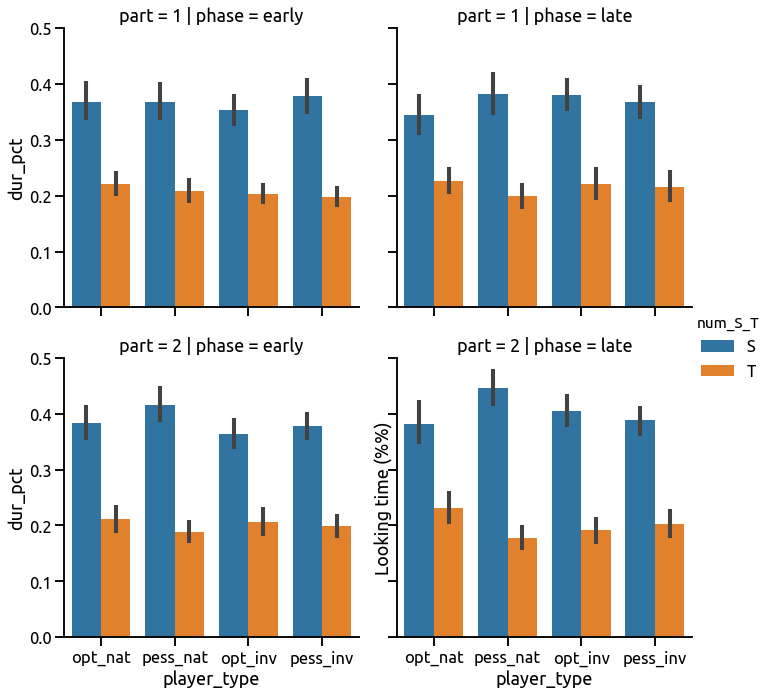

In [264]:
sns.catplot(kind = 'bar', data = trial_fix, x = 'player_type', y = 'dur_pct', hue = 'num_S_T', order = pts,
           col = 'phase', row = 'part')
plt.ylabel('Looking time (%%)');

Cool! So the difference in looking between S and T between Opt and Pess grows over time, as people become acquainted with both the player (within block, early vs late) and the task (between 1st and 2nd occurrence of player type). 

Do people spend more time looking at the diagnostic number on CORRECT trials? Run multiple regression to correct for time (block-trial nr):

## v Scraps / old stuff

In [ ]:
plot_dat = all_fix.groupby(['sub','player_type']).mean().reset_index()


In [130]:
plot_dat = all_fix.groupby(['sub','player_type']).mean().reset_index()
plot_dat

,sub,player_type,S1,S2,T1,T2,S_total,T_total,S_share,T_share,block,trial
0,5,opt_inv,13.15625,95.09375,4.15625,48.43750,108.25000,52.59375,0.119064,0.055721,5.5,80.5
1,5,opt_nat,7.81250,69.03125,4.53125,48.15625,76.84375,52.68750,0.085051,0.058496,3.0,40.5
2,5,pess_inv,52.37500,98.18750,36.06250,61.84375,150.56250,97.90625,0.127430,0.081097,5.5,80.5
3,5,pess_nat,5.65625,104.78125,9.09375,36.25000,110.43750,45.34375,0.120413,0.050363,4.0,56.5
4,6,opt_inv,122.96875,192.31250,59.28125,105.59375,315.28125,164.87500,0.212448,0.103378,5.5,80.5
5,6,opt_nat,37.93750,99.87500,5.43750,93.68750,137.81250,99.12500,0.137909,0.101842,4.5,64.5
6,6,pess_inv,124.75000,227.59375,28.34375,100.68750,352.34375,129.03125,0.254602,0.090380,5.0,72.5
7,6,pess_nat,103.90625,250.46875,28.43750,118.03125,354.37500,146.46875,0.218521,0.080426,3.0,40.5
8,7,opt_inv,103.03125,307.59375,95.43750,115.40625,410.62500,210.84375,0.200593,0.107610,5.5,80.5
9,7,opt_nat,63.62500,249.34375,54.93750,87.78125,312.96875,142.71875,0.182453,0.077938,5.0,72.5


In [131]:
plot_dat = plot_dat[['sub','S_share','T_share','player_type']].melt(
    id_vars = ['sub','player_type'], value_vars = ['S_share','T_share'],
    var_name = 'info_source', value_name = 'time_share').replace(
    to_replace = {'S_share':'S', 'T_share':'T'})


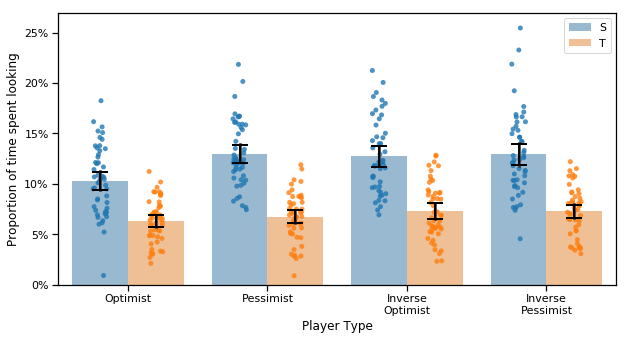

In [159]:
sns.set_context('notebook')
fig, ax = plt.subplots(1,1,figsize=[10,5])
sns.barplot(data = plot_dat, x = 'player_type', hue = 'info_source', y = 'time_share',
           alpha = .5, ax=ax, zorder = 1, order = ['opt_nat', 'pess_nat', 'opt_inv', 'pess_inv'])
hand,lab = ax.get_legend_handles_labels()
sns.stripplot(data = plot_dat, x = 'player_type', hue = 'info_source', y = 'time_share',
             dodge = True, alpha = .8, ax=ax, zorder = 2,
              order = ['opt_nat', 'pess_nat', 'opt_inv', 'pess_inv'])
sns.barplot(data = plot_dat, x = 'player_type', hue = 'info_source', y = 'time_share',
           alpha = 0, errcolor = 'k', errwidth = 2, capsize = .1, zorder = 3, ax=ax,
           order = ['opt_nat', 'pess_nat', 'opt_inv', 'pess_inv'])
plt.legend(hand, lab)
ax.set(xticklabels = ['Optimist','Pessimist','Inverse\nOptimist','Inverse\nPessimist'],
      xlabel = 'Player Type', ylabel = 'Proportion of time spent looking');
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format));
plt.savefig('/Users/jvanbaar/Desktop/S_T_plot.pdf',bbox_inches='tight', transparent = True)

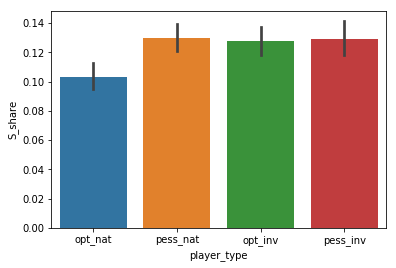

In [143]:
sns.barplot(data = fixations_all[['sub','player_type','S_share']].groupby(
                    ['sub','player_type']).mean().reset_index(),
            order = ['opt_nat', 'pess_nat', 'opt_inv', 'pess_inv'],
            x = 'player_type', y = 'S_share')

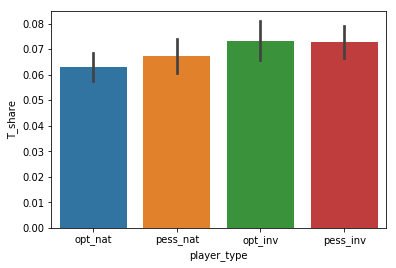

In [144]:
sns.barplot(data = fixations_all[['sub','player_type','T_share']].groupby(
                    ['sub','player_type']).mean().reset_index(),
            order = ['opt_nat', 'pess_nat', 'opt_inv', 'pess_inv'],
            x = 'player_type', y = 'T_share')